# AP Browser

This notebook takes in a trained AP model file and outputs data cleaning labels to the training dataset. First, we load modules and files.

In [2]:
# Load modules
import pickle, math, json
import lgdo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 

# Plot style 
plt.style.use('seaborn-v0_8-notebook')

# Load data 
sto = lgdo.lh5.LH5Store()
tb_dsp, _ = sto.read('detector/dsp', '../data/train_data_dsp.h5')

with open('../data/ap_detector.sav', 'rb') as ap_file:
    ap = pickle.load(ap_file)

Here we define the variables we will use to re-label all exemplars based on their data cleaning category.

In [3]:
ex_label = ap.labels_
cluster_centers = ap.cluster_centers_indices_
wf_norm = tb_dsp['wf_norm']['values'].nda

Here we plot all the exemplars. We also include the exemplar label in the legend since this helps the user re-label all waveforms in terms of data cleaning categories.

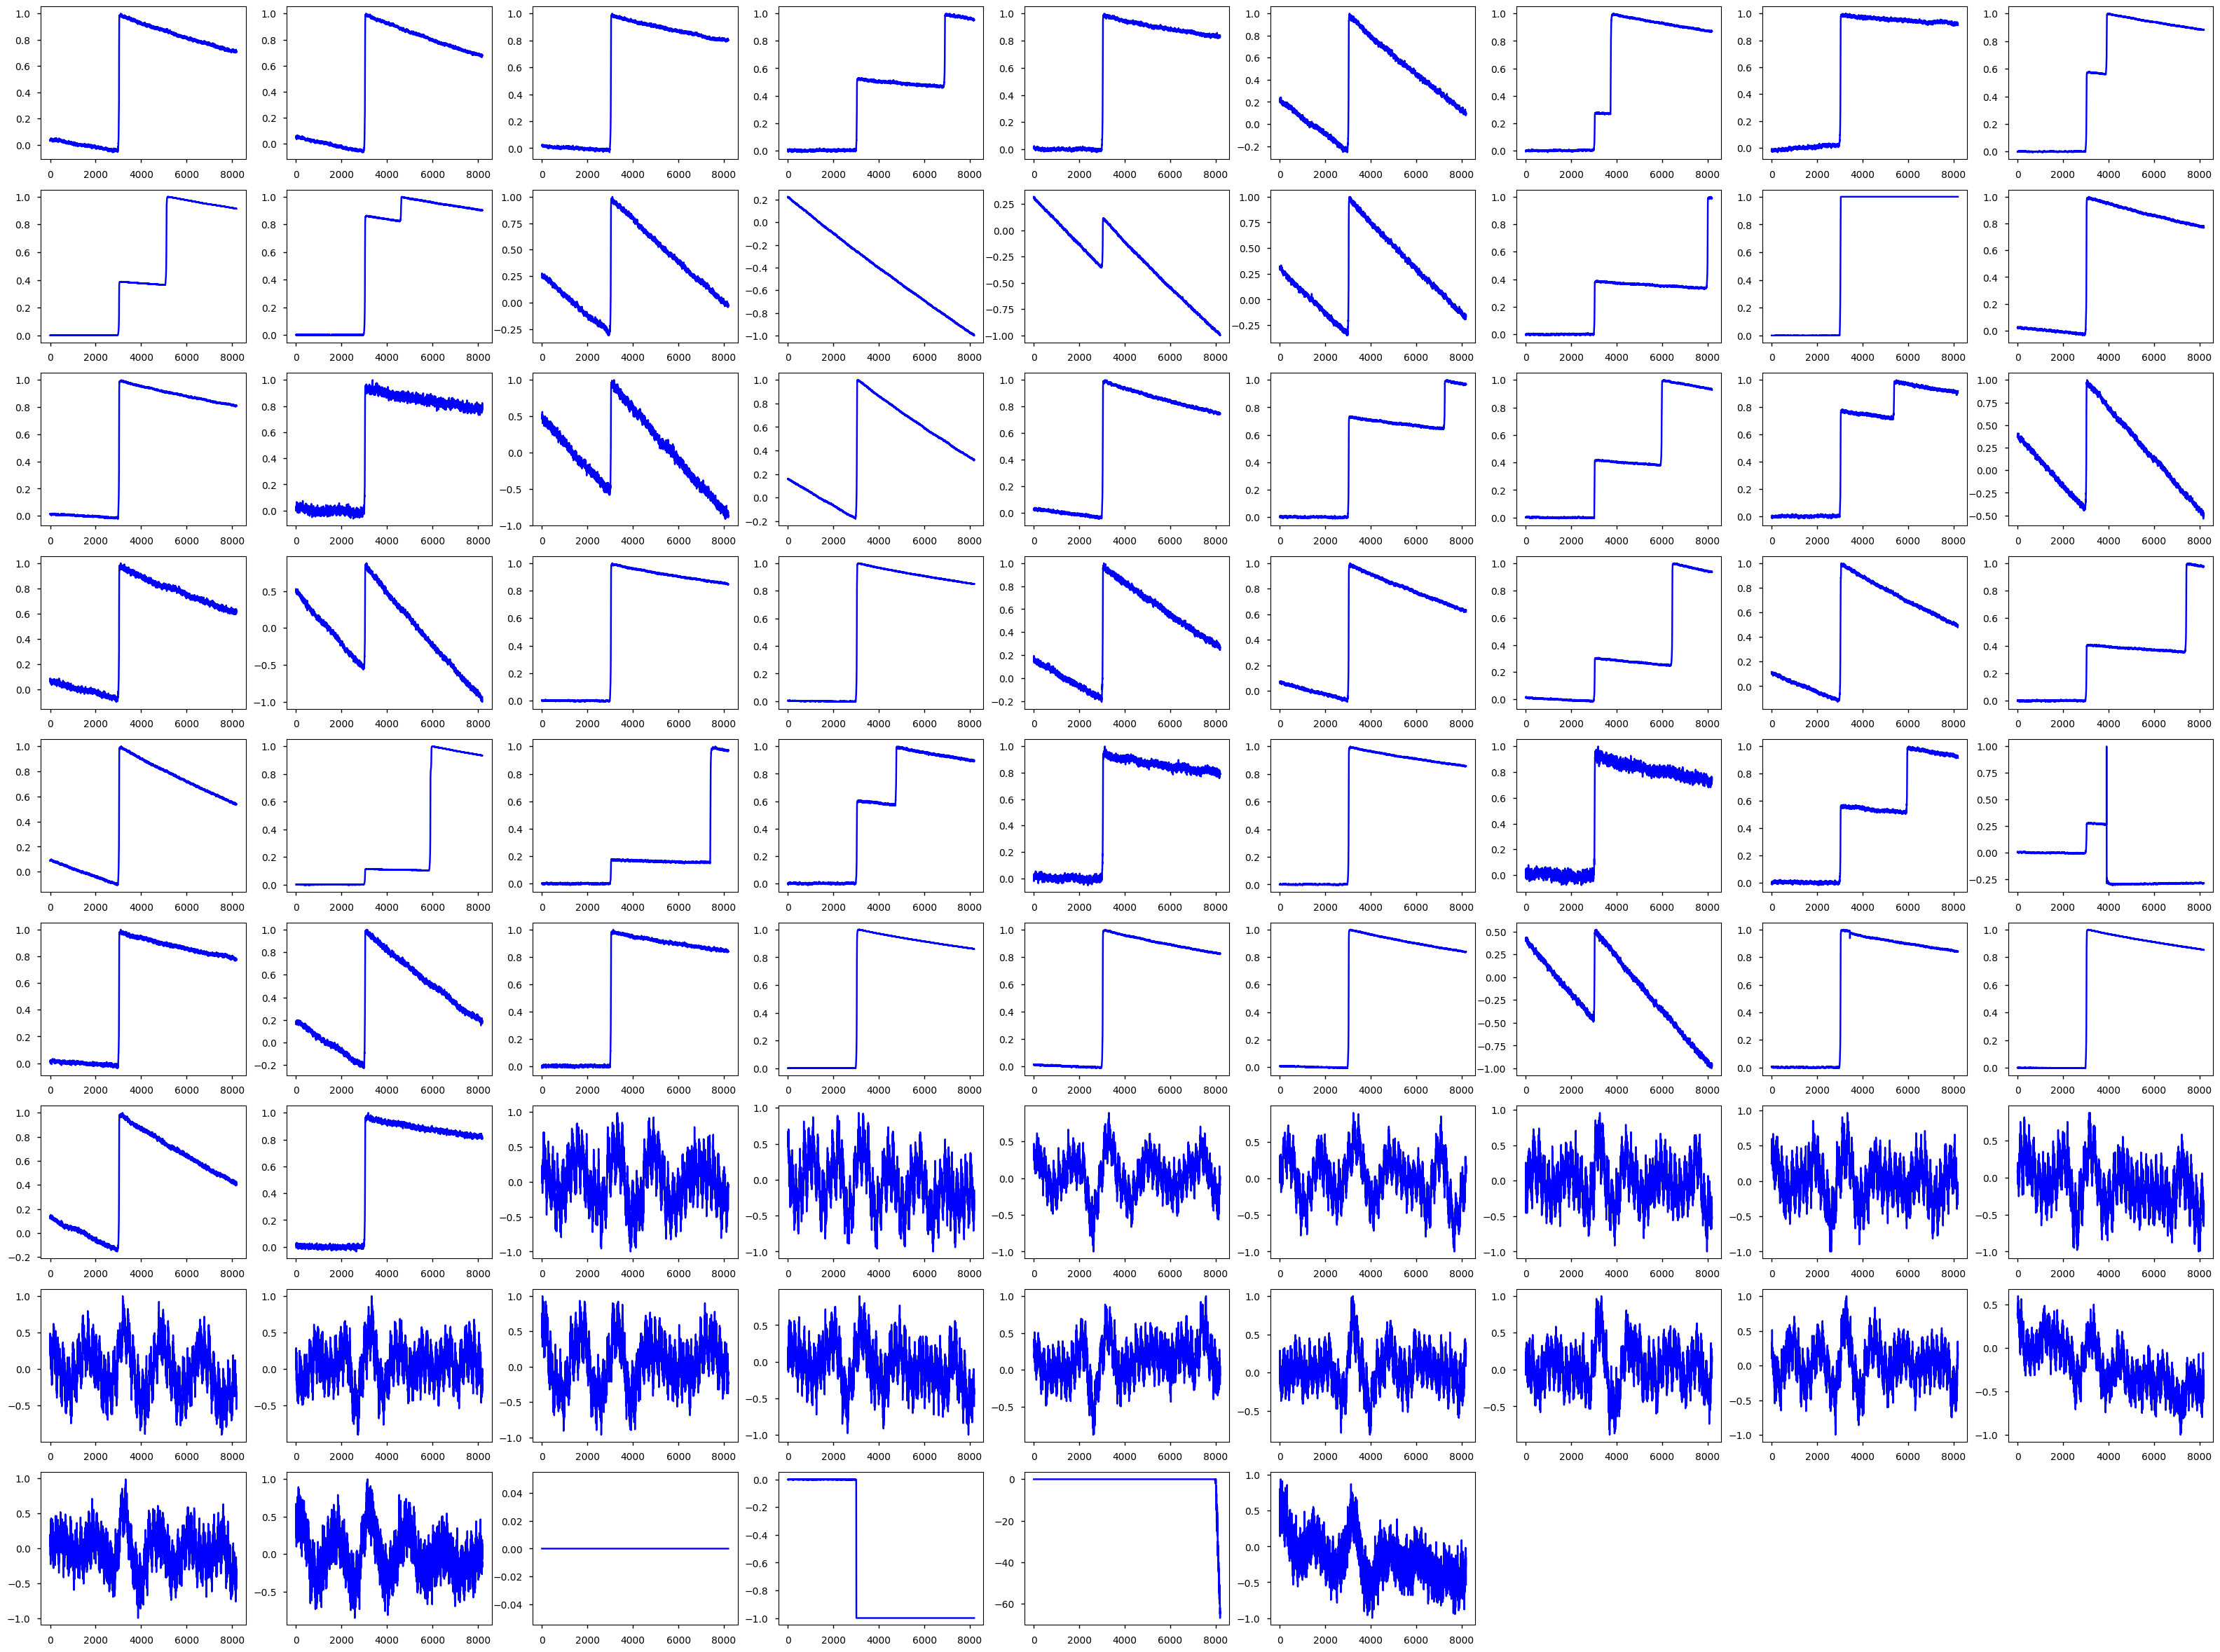

In [9]:
%matplotlib inline

n_exemps = len(cluster_centers)
fig= plt.figure(figsize=(40,30))

for j in range(n_exemps):
    ax = fig.add_subplot(math.ceil((n_exemps)**0.5),math.ceil((n_exemps)**0.5),j+1,
                        axes_class = matplotlib.axes.Axes)
    idx = cluster_centers[j] 
    wf = wf_norm[idx]
    ax.plot(wf, linestyle="-", color='blue',
            label=int(ex_label[idx]))
    ax.legend(loc='best', prop = {'weight':'bold', 'size':40})
file_format = 'pdf'
plt.savefig(f"../plots/exemplars.{file_format}", format=file_format,
            dpi='figure', bbox_inches='tight')

This cell plots a selected exemplar and sample waveforms within the same cluster. This also helps with re-labeling when the exemplar is not representative of all the waveforms in its cluster. 

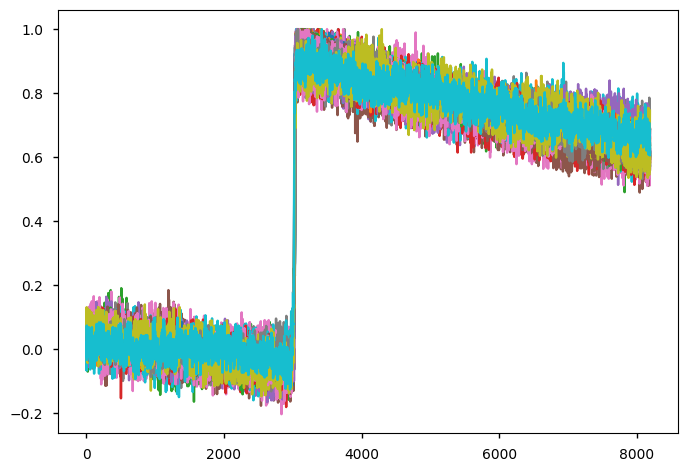

In [10]:
%matplotlib inline

ex = 27

samples = np.where((ex_label == ex))[0][0:50]
fig1, ax1 = plt.subplots(1, 1)
for i in samples:
    ax1.plot(wf_norm[i]) 

In this cell we re-label "by hand" all waveforms in terms of data cleaning categories. The user has to refer to the previous plots and the one below to decide which exemplars belong in what data cleaning category. There will usually multiple exemplars per category, although having one (or no) exemplars in some categories is expected as well. ![Data Cleaning Categories](../plots/ml_categories.svg)

In [4]:
n_events = wf_norm.shape[0]
dc_label = np.zeros(n_events)

normal = [0,1,2,4,7,17,18,19,22,27,29,30,40,
          41,42,45,47,48,49,50,52,53,55]
neg_go = [44,75]
up_slo = []
down_slo = [12,13]
spike = []
x_talk = []
slo_ri = []
early_tr = []
late_tr = []
sat = [16]
soft_pi = [5,11,14,20,21,26,28,31,32,34,36,
           46,51,54]
hard_pi = [3,6,8,9,10,15,23,24,25,33,35,37,
           38,39,43]
bump = []

for i in range(n_events):
    
    # 0: Normal
    if ex_label[i] in normal: dc_label[i] = 0
    # 1: Negative Going
    elif ex_label[i] in neg_go: dc_label[i] = 1
    # 2: Upwards Sloping
    elif ex_label[i] in up_slo: dc_label[i] = 2
    # 3: Downwards Sloping
    elif ex_label[i] in down_slo: dc_label[i] = 3
    # 4: Spike
    elif ex_label[i] in spike: dc_label[i] = 4
    # 5: Crosstalk
    elif ex_label[i] in x_talk: dc_label[i] = 5
    # 6: Slow Rise
    elif ex_label[i] in slo_ri: dc_label[i] = 6
    # 7: Early Trigger
    elif ex_label[i] in early_tr: dc_label[i] = 7
    # 8: Late Trigger
    elif ex_label[i] in late_tr: dc_label[i] = 8
    # 9: Saturation
    elif ex_label[i] in sat: dc_label[i] = 9
    # 10: Soft Pileup
    elif ex_label[i] in soft_pi: dc_label[i] = 10
    # 11: Hard Pileup 
    elif ex_label[i] in hard_pi: dc_label[i] = 11
    # 12: Bump
    elif ex_label[i] in hard_pi: dc_label[i] = 12
    # 13: Noise Trigger/Baseline
    else: dc_label[i] = 13

Now that the events are labeled according to data cleaning tags, we plot all exemplars again to ensure each one is placed under the right category.

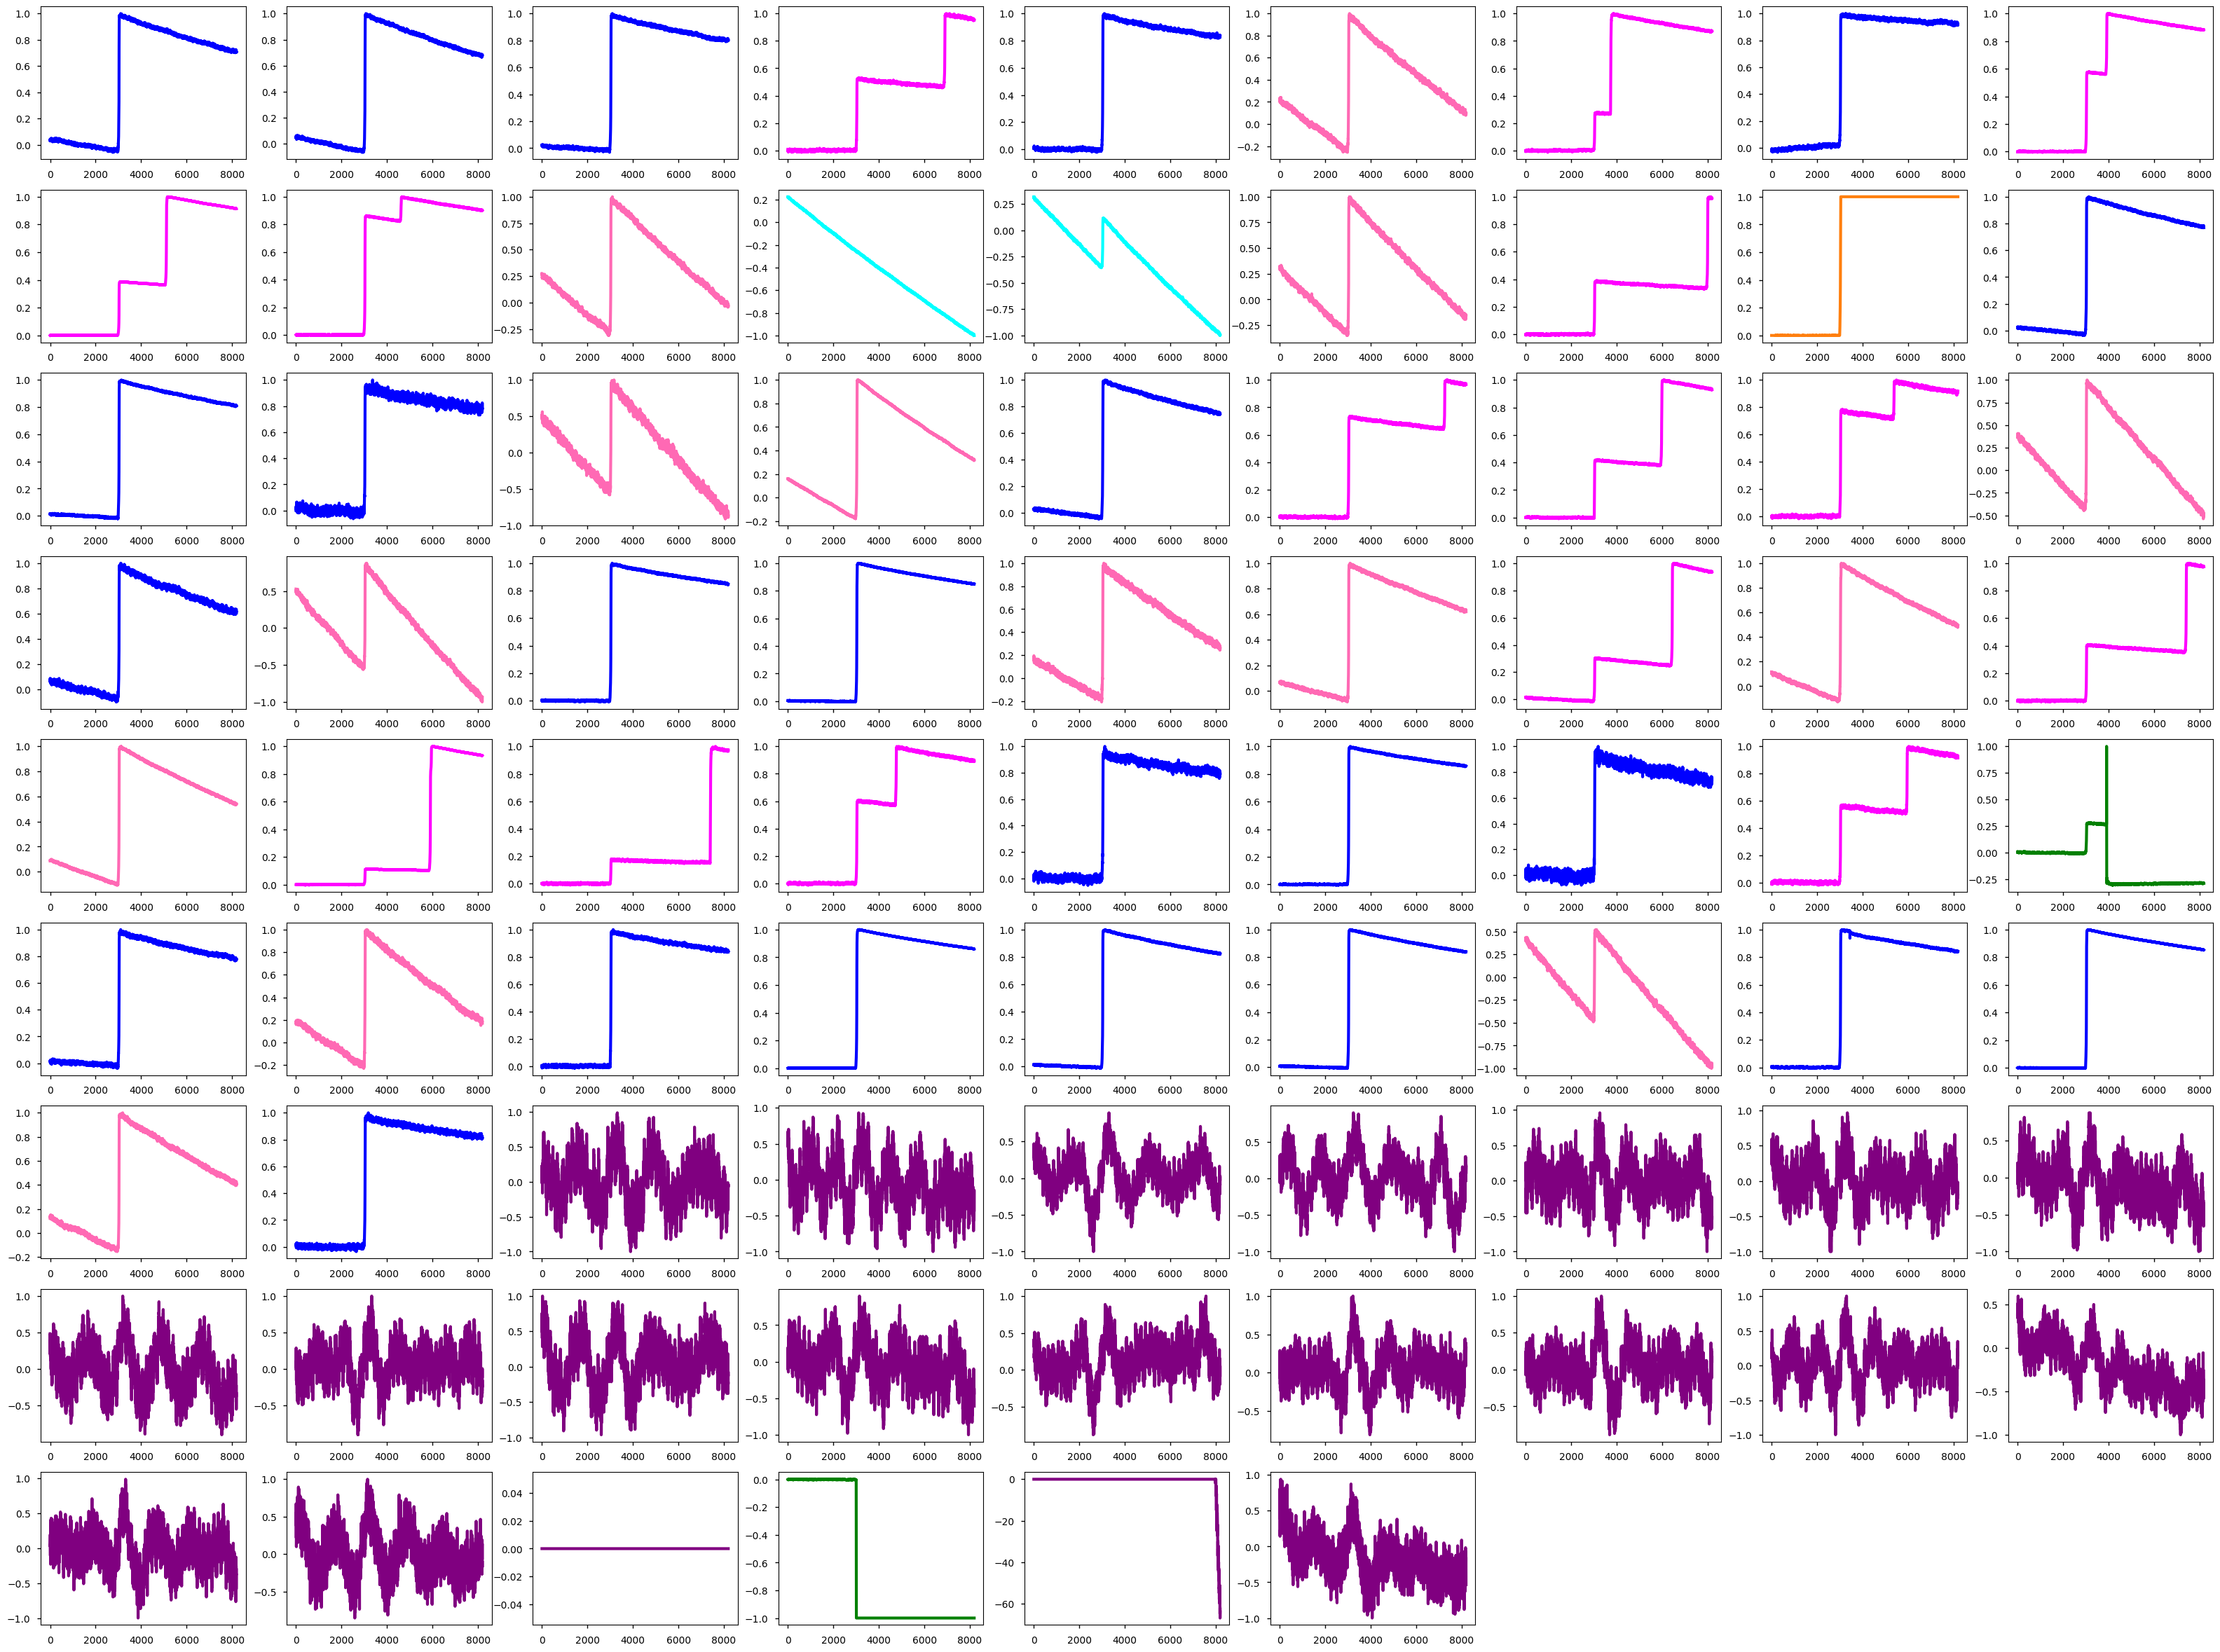

In [12]:
colors = ['blue', 'green', 'red', 'cyan', 'fuchsia', 
          'gold', 'indigo', 'grey', 'maroon', 'tab:orange',
          'hotpink', 'magenta', 'sienna', 'purple']
cmap = matplotlib.colors.ListedColormap(colors)
%matplotlib inline

fig= plt.figure(figsize=(40,30))

for j in range(n_exemps):
    ax = fig.add_subplot(math.ceil((n_exemps)**0.5),math.ceil((n_exemps)**0.5),j+1,
                        axes_class = matplotlib.axes.Axes)
    idx = cluster_centers[j] 
    wf = wf_norm[idx]
    ax.plot(wf, linestyle="-", linewidth=3.0,
            label=int(dc_label[idx]), c=colors[int(dc_label[idx])])
    # ax.legend(prop = {'weight':'bold', 'size':40}, 
              # loc='best', fancybox=True)

file_format = 'pdf'
plt.savefig(f"../plots/exemplars_labeled.{file_format}", format=file_format, 
            dpi='figure', bbox_inches='tight')

After double checking that all exemplars are correctly re-labeled, we save the data cleaning labels onto the data dictionary.

In [5]:
tb_dsp['ex_label'] = lgdo.Array(ex_label)
tb_dsp['dc_label'] = lgdo.Array(dc_label)

In [6]:
# Overwrite file with new fields
sto.write(tb_dsp,
          name = 'dsp',
          lh5_file = '../data/train_data_dsp.h5',
          group = 'detector',
          wo_mode = 'o')

In [8]:
from lgdo.lh5 import show
show('../data/train_data_dsp.h5')

/
└── detector · HDF5 group 
    └── dsp · table{energy,dwt_norm,wf_norm,ex_label,dc_label} 
        ├── dc_label · array<1>{real} 
        ├── dwt_norm · array_of_equalsized_arrays<1,1>{real} 
        ├── energy · array<1>{real} 
        ├── ex_label · array<1>{real} 
        └── wf_norm · table{t0,dt,values} 
            ├── dt · array<1>{real} 
            ├── t0 · array<1>{real} 
            └── values · array_of_equalsized_arrays<1,1>{real} 


Check that waveform labels are the expected ones. 

In [9]:
wfs_norm = tb_dsp['wf_norm']['values'].nda
dc_labels = tb_dsp['dc_label'].nda

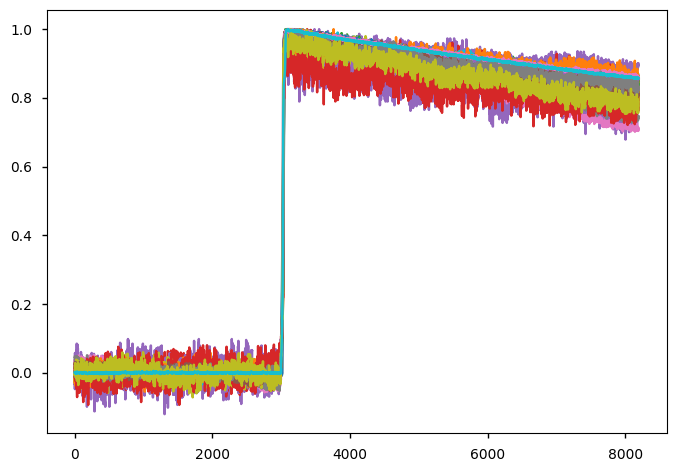

In [12]:
fig, ax = plt.subplots(1,1)

cut = np.where(dc_labels == 0)[0] #plot only normal waveforms
samples = wfs_norm[cut][0:50]

for i in samples:
    ax.plot(i)